## Imports

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(42)
torch.manual_seed(42)

<hr>

## Loading Files

In [17]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy')
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')

print(X.shape, y.shape)

(20000, 6, 28) (20000,)


In [18]:
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
print(X_train.shape, X_val.shape)

(16000, 6, 28) (4000, 6, 28)


<hr>

## Dataset Class

In [19]:
class SimpleDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx])  # shape: (6, 28)
        y = torch.tensor(self.labels[idx])
        return {"x": x, "y": y}

In [20]:
# For evaluation
val_dataset = SimpleDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

<hr>

## Model

In [21]:
################ CNN Backbone
def conv_block(in_channels: int, out_channels: int, dropout_p=0.5) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(p=dropout_p)
    )
 
 
class cnn_dropout(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.conv1 = conv_block(6, 64, dropout_p)
        self.conv2 = conv_block(64, 128, dropout_p)
        self.conv3 = conv_block(128, 256, dropout_p)
        self.conv4 = conv_block(256, 512, dropout_p)
        self.conv5 = conv_block(512, 1024, dropout_p)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        return x.view(x.size(0), -1)
 
 
################ Fully connected network
class FC_dropout(nn.Module):
    def __init__(self,input_dim, dropout_p=0.5):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        return self.fco(x)

In [22]:
# Loading model weights
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')

backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

# Initialize and load models
backbone = cnn_dropout()
backbone.to(device)

fc = FC_dropout(1024)
fc.to(device)

backbone.load_state_dict(backbone_state)
fc.load_state_dict(fc_state)

<All keys matched successfully>

In [23]:
# Enable dropout at inference/prediction (MC dropout)
def enable_dropout(model):
    """Enable dropout layers during test time."""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()  # Keep dropout in training mode

<hr>

## Evaluation Function

In [24]:
def eval_perf(dataloader, backbone, fc, device):
    backbone.eval()
    fc.eval()

    pred=[]
    gt=[]

    with torch.no_grad():
        for batch in dataloader:
            xt, yt = batch["x"].to(device), batch["y"].to(device)

            # Forward pass through backbone and FC head
            features = backbone(xt)
            outputs = fc(features)
            
            yt_pred = torch.argmax(outputs, dim=1)
            pred.extend(yt_pred.cpu().numpy())
            gt.extend(yt.cpu().numpy())

    # Convert to numpy arrays
    pred = np.array(pred)
    gt = np.array(gt)

    # Computing metrics
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    acc = np.mean(pred == gt)
    avg_f1 = f1s.mean()

    # Set models back to train mode
    backbone.train()
    fc.train()

    return f1s, acc, avg_f1

<hr>

## Query Sampler (Aquisition Functions)

In [40]:
# ============= Predictive Entropy ============= 
def predictive_entropy_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, sim=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    mc_probs = []

    with torch.no_grad():
        for _ in tqdm(range(sim), desc='MC Dropout Simulations (PredEntropy)'):
            logits = []
            for i in range(0, len(X_pool), 32):
                x_batch = torch.tensor(X_pool[i:i+32]).float().to(device)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                logits.append(F.softmax(out, dim=1).cpu())
            probs = torch.cat(logits, dim=0)
            mc_probs.append(probs)

    mc_probs = torch.stack(mc_probs)  # Shape: [T, N, C]
    avg_probs = mc_probs.mean(dim=0)  # Shape: [N, C]
    entropy = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)

    topk = torch.topk(entropy, k=k).indices
    return [indices[i.item()] for i in topk]


# ============= BALD (Bayesian AL by Disagreement) ============= 
def bald_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, sim=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    mc_probs = []

    with torch.no_grad():
        for _ in tqdm(range(sim), desc="MC Dropout Simulations (BALD)"):
            logits = []
            for i in range(0, len(X_pool), 32):
                x_batch = torch.tensor(X_pool[i:i+32]).float().to(device)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                probs = F.softmax(out, dim=1).cpu()
                logits.append(probs)
            mc_probs.append(torch.cat(logits, dim=0))

    mc_probs = torch.stack(mc_probs)  # [T, N, C]
    avg_probs = mc_probs.mean(dim=0)  # [N, C]

    # Predictive Entropy
    H = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)  # [N]

    # Expected Entropy
    E_H = -torch.sum(mc_probs * torch.log(mc_probs + 1e-8), dim=2).mean(dim=0)  # [N]

    # BALD = H - E_H
    bald_score = H - E_H
    topk = torch.topk(bald_score, k=k).indices
    return [indices[i.item()] for i in topk]



# ============= Variation Ratios ============= 
def variation_ratio_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, sim=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    preds = []

    with torch.no_grad():
        for _ in tqdm(range(sim), desc="MC Dropout Simulations (VarRatio)"):
            logits = []
            for i in range(0, len(X_pool), 32):
                x_batch = torch.tensor(X_pool[i:i+32]).float().to(device)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                pred = torch.argmax(out, dim=1).cpu()
                logits.append(pred)
            preds.append(torch.cat(logits, dim=0))

    preds = torch.stack(preds)  # [T, N]
    mode_preds = torch.mode(preds, dim=0)[0]  # [N]
    agreement = (preds == mode_preds.unsqueeze(0)).sum(dim=0)  # [N]
    variation_ratio = 1 - agreement.float() / sim

    topk = torch.topk(variation_ratio, k=k).indices
    return [indices[i.item()] for i in topk]

In [44]:
sampling_strategies = {
    "predictive_entropy": predictive_entropy_sampling,
    "bald": bald_sampling,
    "variation_ratio": variation_ratio_sampling,
}

# Create separate pools and histories for each strategy
strategy_pools = {}
strategy_histories = {}

for name in sampling_strategies:
    strategy_pools[name] = {
        "labeled": set(),
        "unlabeled": set(range(len(X_train)))
    }
    
    strategy_histories[name] = {
        "rounds": [],
        "num_labeled": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "val_avg_f1": [],
        "val_f1s": []
    }

<hr>

## Training Loop

In [45]:
def train(backbone, fc, train_loader, device, epochs=5):
    backbone.train()
    fc.train()

    optimizer = torch.optim.Adam(list(backbone.parameters()) + list(fc.parameters()), lr=1e-3)
    train_acc_history = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            xt = batch["x"].to(device)
            yt = batch["y"].to(device)

            optimizer.zero_grad()

            features = backbone(xt)
            outputs = fc(features)
            loss = F.cross_entropy(outputs, yt)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Accuracy calculation
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yt).sum().item()
            total += yt.size(0)

        acc = correct / total
        train_acc_history.append(acc)
            
        if (epoch+1)%5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, Train Acc: {acc*100:.2f}%")

    return train_acc_history

<hr>

## AL Pipeline Loop

In [46]:
num_rounds = 10
epochs = 50
query_size = 100 
sim = 30


for name, query_func in sampling_strategies.items():
    print(f"\n======================")
    print(f" Running strategy: {name.upper()} ")
    print(f"======================")    

    labeled_pool = strategy_pools[name]["labeled"]
    unlabeled_pool = strategy_pools[name]["unlabeled"]
    print('Length of Labeled Pool:', len(labeled_pool))
    print('Length of Unlabeled Pool:', len(unlabeled_pool))

    history = strategy_histories[name]

    for round_num in range(1, num_rounds + 1):
        print(f"\n--- Round {round_num} [{name}] ---")
    
        # Cold start: Re-initialize model at every round
        # backbone = cnn_dropout().to(device)
        # fc = FC_dropout(1024).to(device)
        # backbone.load_state_dict(backbone_state)
        # fc.load_state_dict(fc_state)
        
        # 1. Query k samples
        queried_indices = query_func(
            X=X_train,
            model_backbone=backbone,
            model_fc=fc,
            k=query_size,
            device=device,
            unlabeled_pool=unlabeled_pool,
            sim = sim
        )
    
        # 2. Update pools
        new_indices = set(queried_indices) - labeled_pool  # avoid duplication
        labeled_pool.update(new_indices)
        unlabeled_pool.difference_update(new_indices)
        print('Length of Labeled Pool:', len(labeled_pool))
        print('Length of Unlabeled Pool:', len(unlabeled_pool))
        
        # 3. Build train loader
        train_dataset = SimpleDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
        # 4. Train + Evaluate
        train_acc = train(backbone, fc, train_loader, device, epochs=epochs)
        val_f1s, val_acc, val_avg_f1 = eval_perf(val_dataloader, backbone, fc, device)
        
        print("Per-class F1 scores:", val_f1s)
        print(f"Overall Accuracy: {val_acc * 100:.2f}%")
        print(f"Average F1 Score: {val_avg_f1:.4f}")
    
        # 5. Update history
        history["rounds"].append(round_num)
        history["num_labeled"].append(len(labeled_pool))
        history["train_accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)
        history["val_avg_f1"].append(val_avg_f1)
        history["val_f1s"].append(val_f1s.tolist())


 Running strategy: PREDICTIVE_ENTROPY 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 16000

--- Round 1 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 100
Length of Unlabeled Pool: 15900
Epoch 5/50, Loss: 0.9233, Train Acc: 61.00%
Epoch 10/50, Loss: 0.6846, Train Acc: 72.00%
Epoch 15/50, Loss: 0.5689, Train Acc: 73.00%
Epoch 20/50, Loss: 0.3868, Train Acc: 86.00%
Epoch 25/50, Loss: 0.3461, Train Acc: 88.00%
Epoch 30/50, Loss: 0.3364, Train Acc: 88.00%
Epoch 35/50, Loss: 0.3045, Train Acc: 86.00%
Epoch 40/50, Loss: 0.6236, Train Acc: 83.00%
Epoch 45/50, Loss: 0.2691, Train Acc: 88.00%
Epoch 50/50, Loss: 0.3875, Train Acc: 84.00%
Per-class F1 scores: [0.65321101 0.73091603 0.7148289 ]
Overall Accuracy: 69.17%
Average F1 Score: 0.6997

--- Round 2 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 200
Length of Unlabeled Pool: 15800
Epoch 5/50, Loss: 0.3739, Train Acc: 85.00%
Epoch 10/50, Loss: 0.3537, Train Acc: 84.50%
Epoch 15/50, Loss: 0.3488, Train Acc: 86.50%
Epoch 20/50, Loss: 0.2342, Train Acc: 91.50%
Epoch 25/50, Loss: 0.2255, Train Acc: 87.00%
Epoch 30/50, Loss: 0.3228, Train Acc: 89.00%
Epoch 35/50, Loss: 0.2706, Train Acc: 89.50%
Epoch 40/50, Loss: 0.1779, Train Acc: 93.50%
Epoch 45/50, Loss: 0.1780, Train Acc: 92.50%
Epoch 50/50, Loss: 0.1873, Train Acc: 94.00%
Per-class F1 scores: [0.77278497 0.85714286 0.71865745]
Overall Accuracy: 76.30%
Average F1 Score: 0.7829

--- Round 3 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 300
Length of Unlabeled Pool: 15700
Epoch 5/50, Loss: 0.5356, Train Acc: 81.00%
Epoch 10/50, Loss: 0.4856, Train Acc: 81.00%
Epoch 15/50, Loss: 0.5197, Train Acc: 82.67%
Epoch 20/50, Loss: 0.4192, Train Acc: 82.00%
Epoch 25/50, Loss: 0.2504, Train Acc: 92.67%
Epoch 30/50, Loss: 0.2972, Train Acc: 88.67%
Epoch 35/50, Loss: 0.4079, Train Acc: 84.33%
Epoch 40/50, Loss: 0.2852, Train Acc: 89.67%
Epoch 45/50, Loss: 0.3162, Train Acc: 88.33%
Epoch 50/50, Loss: 0.2725, Train Acc: 89.00%
Per-class F1 scores: [0.8223152  0.84103512 0.82088209]
Overall Accuracy: 82.42%
Average F1 Score: 0.8281

--- Round 4 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 400
Length of Unlabeled Pool: 15600
Epoch 5/50, Loss: 0.4852, Train Acc: 81.25%
Epoch 10/50, Loss: 0.4748, Train Acc: 83.25%
Epoch 15/50, Loss: 0.3523, Train Acc: 87.25%
Epoch 20/50, Loss: 0.3117, Train Acc: 87.00%
Epoch 25/50, Loss: 0.3324, Train Acc: 88.00%
Epoch 30/50, Loss: 0.2763, Train Acc: 90.50%
Epoch 35/50, Loss: 0.3023, Train Acc: 86.25%
Epoch 40/50, Loss: 0.3255, Train Acc: 88.00%
Epoch 45/50, Loss: 0.2344, Train Acc: 90.50%
Epoch 50/50, Loss: 0.2360, Train Acc: 91.00%
Per-class F1 scores: [0.84280199 0.84380952 0.8465704 ]
Overall Accuracy: 84.45%
Average F1 Score: 0.8444

--- Round 5 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 500
Length of Unlabeled Pool: 15500
Epoch 5/50, Loss: 0.3786, Train Acc: 84.40%
Epoch 10/50, Loss: 0.4706, Train Acc: 82.20%
Epoch 15/50, Loss: 0.3465, Train Acc: 85.00%
Epoch 20/50, Loss: 0.3517, Train Acc: 85.60%
Epoch 25/50, Loss: 0.3630, Train Acc: 85.20%
Epoch 30/50, Loss: 0.3113, Train Acc: 88.60%
Epoch 35/50, Loss: 0.2795, Train Acc: 89.20%
Epoch 40/50, Loss: 0.3042, Train Acc: 89.20%
Epoch 45/50, Loss: 0.2992, Train Acc: 89.40%
Epoch 50/50, Loss: 0.2557, Train Acc: 90.80%
Per-class F1 scores: [0.83658009 0.8498528  0.83409437]
Overall Accuracy: 83.73%
Average F1 Score: 0.8402

--- Round 6 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Length of Labeled Pool: 600
Length of Unlabeled Pool: 15400
Epoch 5/50, Loss: 0.3331, Train Acc: 87.17%
Epoch 10/50, Loss: 0.3540, Train Acc: 85.67%
Epoch 15/50, Loss: 0.3534, Train Acc: 85.50%
Epoch 20/50, Loss: 0.3188, Train Acc: 88.17%
Epoch 25/50, Loss: 0.2780, Train Acc: 88.67%
Epoch 30/50, Loss: 0.2740, Train Acc: 89.83%
Epoch 35/50, Loss: 0.2841, Train Acc: 89.33%
Epoch 40/50, Loss: 0.2651, Train Acc: 89.67%
Epoch 45/50, Loss: 0.2633, Train Acc: 89.67%
Epoch 50/50, Loss: 0.2922, Train Acc: 88.00%
Per-class F1 scores: [0.8255934  0.86165274 0.79225468]
Overall Accuracy: 81.77%
Average F1 Score: 0.8265

--- Round 7 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Length of Labeled Pool: 700
Length of Unlabeled Pool: 15300
Epoch 5/50, Loss: 0.4546, Train Acc: 82.29%
Epoch 10/50, Loss: 0.3174, Train Acc: 87.86%
Epoch 15/50, Loss: 0.3055, Train Acc: 87.57%
Epoch 20/50, Loss: 0.3122, Train Acc: 88.29%
Epoch 25/50, Loss: 0.2771, Train Acc: 88.57%
Epoch 30/50, Loss: 0.3386, Train Acc: 86.86%
Epoch 35/50, Loss: 0.2988, Train Acc: 88.71%
Epoch 40/50, Loss: 0.2225, Train Acc: 91.14%
Epoch 45/50, Loss: 0.2778, Train Acc: 89.86%
Epoch 50/50, Loss: 0.3065, Train Acc: 87.29%
Per-class F1 scores: [0.82907662 0.86319846 0.83436305]
Overall Accuracy: 83.58%
Average F1 Score: 0.8422

--- Round 8 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:29<00:00,  1.03it/s]


Length of Labeled Pool: 800
Length of Unlabeled Pool: 15200
Epoch 5/50, Loss: 0.3003, Train Acc: 88.75%
Epoch 10/50, Loss: 0.3434, Train Acc: 87.62%
Epoch 15/50, Loss: 0.2970, Train Acc: 88.62%
Epoch 20/50, Loss: 0.2705, Train Acc: 89.88%
Epoch 25/50, Loss: 0.2828, Train Acc: 89.88%
Epoch 30/50, Loss: 0.3098, Train Acc: 88.75%
Epoch 35/50, Loss: 0.2699, Train Acc: 89.25%
Epoch 40/50, Loss: 0.2973, Train Acc: 89.25%
Epoch 45/50, Loss: 0.2933, Train Acc: 89.12%
Epoch 50/50, Loss: 0.3675, Train Acc: 86.38%
Per-class F1 scores: [0.83333333 0.87118977 0.82115086]
Overall Accuracy: 83.33%
Average F1 Score: 0.8419

--- Round 9 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


Length of Labeled Pool: 900
Length of Unlabeled Pool: 15100
Epoch 5/50, Loss: 0.3422, Train Acc: 88.00%
Epoch 10/50, Loss: 0.3173, Train Acc: 87.56%
Epoch 15/50, Loss: 0.3533, Train Acc: 88.33%
Epoch 20/50, Loss: 0.3648, Train Acc: 87.11%
Epoch 25/50, Loss: 0.3083, Train Acc: 86.78%
Epoch 30/50, Loss: 0.3850, Train Acc: 88.44%
Epoch 35/50, Loss: 0.3109, Train Acc: 88.44%
Epoch 40/50, Loss: 0.2999, Train Acc: 87.78%
Epoch 45/50, Loss: 0.2755, Train Acc: 89.44%
Epoch 50/50, Loss: 0.2897, Train Acc: 88.00%
Per-class F1 scores: [0.84351464 0.8713615  0.84477612]
Overall Accuracy: 84.78%
Average F1 Score: 0.8532

--- Round 10 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


Length of Labeled Pool: 1000
Length of Unlabeled Pool: 15000
Epoch 5/50, Loss: 0.3183, Train Acc: 87.60%
Epoch 10/50, Loss: 0.3406, Train Acc: 87.20%
Epoch 15/50, Loss: 0.3070, Train Acc: 88.90%
Epoch 20/50, Loss: 0.3687, Train Acc: 87.00%
Epoch 25/50, Loss: 0.3079, Train Acc: 88.20%
Epoch 30/50, Loss: 0.3029, Train Acc: 88.10%
Epoch 35/50, Loss: 0.2984, Train Acc: 89.70%
Epoch 40/50, Loss: 0.2804, Train Acc: 89.50%
Epoch 45/50, Loss: 0.2997, Train Acc: 87.70%
Epoch 50/50, Loss: 0.2937, Train Acc: 88.40%
Per-class F1 scores: [0.84974373 0.86660175 0.84078383]
Overall Accuracy: 84.82%
Average F1 Score: 0.8524

 Running strategy: BALD 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 16000

--- Round 1 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 100
Length of Unlabeled Pool: 15900
Epoch 5/50, Loss: 0.6996, Train Acc: 81.00%
Epoch 10/50, Loss: 0.3422, Train Acc: 88.00%
Epoch 15/50, Loss: 0.2122, Train Acc: 88.00%
Epoch 20/50, Loss: 0.2092, Train Acc: 92.00%
Epoch 25/50, Loss: 0.1198, Train Acc: 95.00%
Epoch 30/50, Loss: 0.6668, Train Acc: 92.00%
Epoch 35/50, Loss: 0.2901, Train Acc: 94.00%
Epoch 40/50, Loss: 0.1312, Train Acc: 97.00%
Epoch 45/50, Loss: 0.7270, Train Acc: 91.00%
Epoch 50/50, Loss: 0.2541, Train Acc: 93.00%
Per-class F1 scores: [0.77410618 0.79692012 0.76659529]
Overall Accuracy: 77.40%
Average F1 Score: 0.7792

--- Round 2 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 200
Length of Unlabeled Pool: 15800
Epoch 5/50, Loss: 0.2887, Train Acc: 90.50%
Epoch 10/50, Loss: 0.2616, Train Acc: 90.50%
Epoch 15/50, Loss: 0.2130, Train Acc: 95.00%
Epoch 20/50, Loss: 0.1508, Train Acc: 94.50%
Epoch 25/50, Loss: 0.1594, Train Acc: 94.00%
Epoch 30/50, Loss: 0.1984, Train Acc: 93.00%
Epoch 35/50, Loss: 0.2572, Train Acc: 91.00%
Epoch 40/50, Loss: 0.2007, Train Acc: 96.50%
Epoch 45/50, Loss: 0.0839, Train Acc: 97.00%
Epoch 50/50, Loss: 0.0929, Train Acc: 97.50%
Per-class F1 scores: [0.80116788 0.85209302 0.81828571]
Overall Accuracy: 81.55%
Average F1 Score: 0.8238

--- Round 3 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 300
Length of Unlabeled Pool: 15700
Epoch 5/50, Loss: 0.2906, Train Acc: 88.33%
Epoch 10/50, Loss: 0.2496, Train Acc: 91.67%
Epoch 15/50, Loss: 0.2240, Train Acc: 91.33%
Epoch 20/50, Loss: 0.1813, Train Acc: 93.00%
Epoch 25/50, Loss: 0.1576, Train Acc: 95.00%
Epoch 30/50, Loss: 0.1309, Train Acc: 95.33%
Epoch 35/50, Loss: 0.1970, Train Acc: 92.67%
Epoch 40/50, Loss: 0.1990, Train Acc: 94.00%
Epoch 45/50, Loss: 0.1714, Train Acc: 93.67%
Epoch 50/50, Loss: 0.1554, Train Acc: 94.67%
Per-class F1 scores: [0.83828017 0.86527514 0.83627656]
Overall Accuracy: 84.10%
Average F1 Score: 0.8466

--- Round 4 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 400
Length of Unlabeled Pool: 15600
Epoch 5/50, Loss: 0.3322, Train Acc: 87.75%
Epoch 10/50, Loss: 0.2425, Train Acc: 92.00%
Epoch 15/50, Loss: 0.2159, Train Acc: 92.25%
Epoch 20/50, Loss: 0.1923, Train Acc: 92.75%
Epoch 25/50, Loss: 0.1903, Train Acc: 92.25%
Epoch 30/50, Loss: 0.1686, Train Acc: 93.75%
Epoch 35/50, Loss: 0.1133, Train Acc: 96.50%
Epoch 40/50, Loss: 0.1322, Train Acc: 94.50%
Epoch 45/50, Loss: 0.2005, Train Acc: 92.75%
Epoch 50/50, Loss: 0.1414, Train Acc: 94.25%
Per-class F1 scores: [0.821572   0.86266925 0.83045977]
Overall Accuracy: 83.08%
Average F1 Score: 0.8382

--- Round 5 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 500
Length of Unlabeled Pool: 15500
Epoch 5/50, Loss: 0.3322, Train Acc: 88.20%
Epoch 10/50, Loss: 0.2228, Train Acc: 91.40%
Epoch 15/50, Loss: 0.2396, Train Acc: 93.80%
Epoch 20/50, Loss: 0.2298, Train Acc: 90.00%
Epoch 25/50, Loss: 0.1699, Train Acc: 94.00%
Epoch 30/50, Loss: 0.2240, Train Acc: 90.80%
Epoch 35/50, Loss: 0.1919, Train Acc: 92.40%
Epoch 40/50, Loss: 0.1504, Train Acc: 94.60%
Epoch 45/50, Loss: 0.1325, Train Acc: 94.40%
Epoch 50/50, Loss: 0.2087, Train Acc: 93.40%
Per-class F1 scores: [0.83834049 0.86635071 0.84521739]
Overall Accuracy: 84.50%
Average F1 Score: 0.8500

--- Round 6 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Length of Labeled Pool: 600
Length of Unlabeled Pool: 15400
Epoch 5/50, Loss: 0.2352, Train Acc: 92.17%
Epoch 10/50, Loss: 0.2295, Train Acc: 91.33%
Epoch 15/50, Loss: 0.1696, Train Acc: 93.33%
Epoch 20/50, Loss: 0.2149, Train Acc: 91.00%
Epoch 25/50, Loss: 0.2150, Train Acc: 93.67%
Epoch 30/50, Loss: 0.2002, Train Acc: 91.33%
Epoch 35/50, Loss: 0.1999, Train Acc: 92.67%
Epoch 40/50, Loss: 0.1621, Train Acc: 94.33%
Epoch 45/50, Loss: 0.1690, Train Acc: 94.00%
Epoch 50/50, Loss: 0.1376, Train Acc: 95.83%
Per-class F1 scores: [0.85833102 0.8647619  0.86090338]
Overall Accuracy: 86.02%
Average F1 Score: 0.8613

--- Round 7 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.03it/s]


Length of Labeled Pool: 700
Length of Unlabeled Pool: 15300
Epoch 5/50, Loss: 0.2787, Train Acc: 90.14%
Epoch 10/50, Loss: 0.2497, Train Acc: 91.29%
Epoch 15/50, Loss: 0.2643, Train Acc: 90.29%
Epoch 20/50, Loss: 0.1829, Train Acc: 93.43%
Epoch 25/50, Loss: 0.2650, Train Acc: 90.43%
Epoch 30/50, Loss: 0.1986, Train Acc: 93.57%
Epoch 35/50, Loss: 0.1684, Train Acc: 94.43%
Epoch 40/50, Loss: 0.1964, Train Acc: 93.57%
Epoch 45/50, Loss: 0.1740, Train Acc: 93.71%
Epoch 50/50, Loss: 0.1750, Train Acc: 93.86%
Per-class F1 scores: [0.85595568 0.87488241 0.85061617]
Overall Accuracy: 85.62%
Average F1 Score: 0.8605

--- Round 8 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.03it/s]


Length of Labeled Pool: 800
Length of Unlabeled Pool: 15200
Epoch 5/50, Loss: 0.2582, Train Acc: 90.88%
Epoch 10/50, Loss: 0.2153, Train Acc: 91.88%
Epoch 15/50, Loss: 0.2123, Train Acc: 91.75%
Epoch 20/50, Loss: 0.2202, Train Acc: 91.38%
Epoch 25/50, Loss: 0.1908, Train Acc: 93.12%
Epoch 30/50, Loss: 0.1862, Train Acc: 92.62%
Epoch 35/50, Loss: 0.1774, Train Acc: 93.38%
Epoch 40/50, Loss: 0.2000, Train Acc: 92.38%
Epoch 45/50, Loss: 0.1945, Train Acc: 91.50%
Epoch 50/50, Loss: 0.1640, Train Acc: 93.62%
Per-class F1 scores: [0.87417943 0.88       0.86893643]
Overall Accuracy: 87.28%
Average F1 Score: 0.8744

--- Round 9 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


Length of Labeled Pool: 900
Length of Unlabeled Pool: 15100
Epoch 5/50, Loss: 0.2761, Train Acc: 91.11%
Epoch 10/50, Loss: 0.2524, Train Acc: 91.56%
Epoch 15/50, Loss: 0.2474, Train Acc: 91.67%
Epoch 20/50, Loss: 0.2194, Train Acc: 91.67%
Epoch 25/50, Loss: 0.2906, Train Acc: 89.33%
Epoch 30/50, Loss: 0.2353, Train Acc: 91.22%
Epoch 35/50, Loss: 0.1969, Train Acc: 93.00%
Epoch 40/50, Loss: 0.1845, Train Acc: 93.44%
Epoch 45/50, Loss: 0.1987, Train Acc: 93.11%
Epoch 50/50, Loss: 0.2138, Train Acc: 92.89%
Per-class F1 scores: [0.8728466  0.87572816 0.86568065]
Overall Accuracy: 87.02%
Average F1 Score: 0.8714

--- Round 10 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Length of Labeled Pool: 1000
Length of Unlabeled Pool: 15000
Epoch 5/50, Loss: 0.2648, Train Acc: 89.90%
Epoch 10/50, Loss: 0.2365, Train Acc: 90.90%
Epoch 15/50, Loss: 0.2454, Train Acc: 91.30%
Epoch 20/50, Loss: 0.2288, Train Acc: 91.70%
Epoch 25/50, Loss: 0.1985, Train Acc: 92.00%
Epoch 30/50, Loss: 0.2360, Train Acc: 91.60%
Epoch 35/50, Loss: 0.2167, Train Acc: 91.90%
Epoch 40/50, Loss: 0.2739, Train Acc: 90.10%
Epoch 45/50, Loss: 0.1997, Train Acc: 92.50%
Epoch 50/50, Loss: 0.2105, Train Acc: 91.70%
Per-class F1 scores: [0.88239979 0.87881773 0.87072716]
Overall Accuracy: 87.72%
Average F1 Score: 0.8773

 Running strategy: VARIATION_RATIO 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 16000

--- Round 1 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 100
Length of Unlabeled Pool: 15900
Epoch 5/50, Loss: 0.9285, Train Acc: 69.00%
Epoch 10/50, Loss: 0.4996, Train Acc: 73.00%
Epoch 15/50, Loss: 0.4444, Train Acc: 83.00%
Epoch 20/50, Loss: 0.3919, Train Acc: 93.00%
Epoch 25/50, Loss: 0.3781, Train Acc: 90.00%
Epoch 30/50, Loss: 0.3415, Train Acc: 92.00%
Epoch 35/50, Loss: 0.1925, Train Acc: 93.00%
Epoch 40/50, Loss: 0.2573, Train Acc: 92.00%
Epoch 45/50, Loss: 0.5037, Train Acc: 94.00%
Epoch 50/50, Loss: 0.2952, Train Acc: 91.00%
Per-class F1 scores: [0.83678683 0.87863591 0.83333333]
Overall Accuracy: 84.05%
Average F1 Score: 0.8496

--- Round 2 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 200
Length of Unlabeled Pool: 15800
Epoch 5/50, Loss: 0.4253, Train Acc: 85.50%
Epoch 10/50, Loss: 0.4051, Train Acc: 87.50%
Epoch 15/50, Loss: 0.3632, Train Acc: 89.00%
Epoch 20/50, Loss: 0.2933, Train Acc: 93.00%
Epoch 25/50, Loss: 0.1550, Train Acc: 94.50%
Epoch 30/50, Loss: 0.2006, Train Acc: 92.50%
Epoch 35/50, Loss: 0.2021, Train Acc: 95.00%
Epoch 40/50, Loss: 0.1795, Train Acc: 95.00%
Epoch 45/50, Loss: 0.3135, Train Acc: 90.50%
Epoch 50/50, Loss: 0.1409, Train Acc: 95.50%
Per-class F1 scores: [0.88593877 0.87684729 0.87978142]
Overall Accuracy: 88.22%
Average F1 Score: 0.8809

--- Round 3 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 300
Length of Unlabeled Pool: 15700
Epoch 5/50, Loss: 0.4341, Train Acc: 84.67%
Epoch 10/50, Loss: 0.3036, Train Acc: 90.00%
Epoch 15/50, Loss: 0.2812, Train Acc: 87.67%
Epoch 20/50, Loss: 0.1989, Train Acc: 94.00%
Epoch 25/50, Loss: 0.2089, Train Acc: 92.67%
Epoch 30/50, Loss: 0.2146, Train Acc: 91.00%
Epoch 35/50, Loss: 0.2449, Train Acc: 93.00%
Epoch 40/50, Loss: 0.1480, Train Acc: 93.33%
Epoch 45/50, Loss: 0.2011, Train Acc: 95.67%
Epoch 50/50, Loss: 0.1582, Train Acc: 92.67%
Per-class F1 scores: [0.85135521 0.84137931 0.84885057]
Overall Accuracy: 84.90%
Average F1 Score: 0.8472

--- Round 4 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 400
Length of Unlabeled Pool: 15600
Epoch 5/50, Loss: 0.2199, Train Acc: 92.75%
Epoch 10/50, Loss: 0.1798, Train Acc: 92.75%
Epoch 15/50, Loss: 0.2080, Train Acc: 92.50%
Epoch 20/50, Loss: 0.2534, Train Acc: 90.25%
Epoch 25/50, Loss: 0.1621, Train Acc: 94.00%
Epoch 30/50, Loss: 0.1606, Train Acc: 94.50%
Epoch 35/50, Loss: 0.1969, Train Acc: 92.50%
Epoch 40/50, Loss: 0.1213, Train Acc: 95.25%
Epoch 45/50, Loss: 0.2038, Train Acc: 94.25%
Epoch 50/50, Loss: 0.1065, Train Acc: 96.75%
Per-class F1 scores: [0.87094972 0.8630137  0.86698058]
Overall Accuracy: 86.83%
Average F1 Score: 0.8670

--- Round 5 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 500
Length of Unlabeled Pool: 15500
Epoch 5/50, Loss: 0.3086, Train Acc: 88.80%
Epoch 10/50, Loss: 0.2037, Train Acc: 92.20%
Epoch 15/50, Loss: 0.2165, Train Acc: 92.00%
Epoch 20/50, Loss: 0.1599, Train Acc: 94.40%
Epoch 25/50, Loss: 0.1364, Train Acc: 95.40%
Epoch 30/50, Loss: 0.1527, Train Acc: 93.00%
Epoch 35/50, Loss: 0.1443, Train Acc: 94.40%
Epoch 40/50, Loss: 0.1237, Train Acc: 94.80%
Epoch 45/50, Loss: 0.1465, Train Acc: 95.60%
Epoch 50/50, Loss: 0.1523, Train Acc: 93.80%
Per-class F1 scores: [0.87655344 0.86939571 0.87026543]
Overall Accuracy: 87.30%
Average F1 Score: 0.8721

--- Round 6 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 600
Length of Unlabeled Pool: 15400
Epoch 5/50, Loss: 0.2519, Train Acc: 89.67%
Epoch 10/50, Loss: 0.2398, Train Acc: 91.33%
Epoch 15/50, Loss: 0.2150, Train Acc: 89.83%
Epoch 20/50, Loss: 0.2211, Train Acc: 91.50%
Epoch 25/50, Loss: 0.2043, Train Acc: 91.33%
Epoch 30/50, Loss: 0.1570, Train Acc: 94.50%
Epoch 35/50, Loss: 0.1899, Train Acc: 93.17%
Epoch 40/50, Loss: 0.1816, Train Acc: 92.83%
Epoch 45/50, Loss: 0.1629, Train Acc: 93.33%
Epoch 50/50, Loss: 0.1349, Train Acc: 95.33%
Per-class F1 scores: [0.88186356 0.87573964 0.8816568 ]
Overall Accuracy: 88.10%
Average F1 Score: 0.8798

--- Round 7 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Length of Labeled Pool: 700
Length of Unlabeled Pool: 15300
Epoch 5/50, Loss: 0.2554, Train Acc: 90.43%
Epoch 10/50, Loss: 0.2685, Train Acc: 90.43%
Epoch 15/50, Loss: 0.1997, Train Acc: 91.71%
Epoch 20/50, Loss: 0.2023, Train Acc: 91.14%
Epoch 25/50, Loss: 0.2108, Train Acc: 90.71%
Epoch 30/50, Loss: 0.2210, Train Acc: 93.14%
Epoch 35/50, Loss: 0.2039, Train Acc: 92.43%
Epoch 40/50, Loss: 0.1741, Train Acc: 93.00%
Epoch 45/50, Loss: 0.1772, Train Acc: 94.00%
Epoch 50/50, Loss: 0.1906, Train Acc: 93.00%
Per-class F1 scores: [0.88438356 0.8756027  0.88198008]
Overall Accuracy: 88.22%
Average F1 Score: 0.8807

--- Round 8 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.03it/s]


Length of Labeled Pool: 800
Length of Unlabeled Pool: 15200
Epoch 5/50, Loss: 0.2508, Train Acc: 90.00%
Epoch 10/50, Loss: 0.2088, Train Acc: 91.75%
Epoch 15/50, Loss: 0.2041, Train Acc: 92.38%
Epoch 20/50, Loss: 0.2239, Train Acc: 91.12%
Epoch 25/50, Loss: 0.1806, Train Acc: 93.38%
Epoch 30/50, Loss: 0.2090, Train Acc: 92.25%
Epoch 35/50, Loss: 0.2096, Train Acc: 92.62%
Epoch 40/50, Loss: 0.1582, Train Acc: 93.38%
Epoch 45/50, Loss: 0.1854, Train Acc: 92.50%
Epoch 50/50, Loss: 0.1645, Train Acc: 93.75%
Per-class F1 scores: [0.87923497 0.8666036  0.87420043]
Overall Accuracy: 87.55%
Average F1 Score: 0.8733

--- Round 9 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.03it/s]


Length of Labeled Pool: 900
Length of Unlabeled Pool: 15100
Epoch 5/50, Loss: 0.3981, Train Acc: 89.56%
Epoch 10/50, Loss: 0.2354, Train Acc: 91.11%
Epoch 15/50, Loss: 0.2485, Train Acc: 90.00%
Epoch 20/50, Loss: 0.3455, Train Acc: 89.89%
Epoch 25/50, Loss: 0.2225, Train Acc: 91.44%
Epoch 30/50, Loss: 0.3226, Train Acc: 91.33%
Epoch 35/50, Loss: 0.2467, Train Acc: 90.67%
Epoch 40/50, Loss: 0.1989, Train Acc: 93.33%
Epoch 45/50, Loss: 0.2712, Train Acc: 91.33%
Epoch 50/50, Loss: 0.2611, Train Acc: 92.22%
Per-class F1 scores: [0.89218107 0.88803089 0.88641157]
Overall Accuracy: 88.92%
Average F1 Score: 0.8889

--- Round 10 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


Length of Labeled Pool: 1000
Length of Unlabeled Pool: 15000
Epoch 5/50, Loss: 0.3195, Train Acc: 88.10%
Epoch 10/50, Loss: 0.2903, Train Acc: 89.20%
Epoch 15/50, Loss: 0.2614, Train Acc: 89.00%
Epoch 20/50, Loss: 0.2450, Train Acc: 89.90%
Epoch 25/50, Loss: 0.2425, Train Acc: 92.10%
Epoch 30/50, Loss: 0.2029, Train Acc: 91.40%
Epoch 35/50, Loss: 0.2123, Train Acc: 92.50%
Epoch 40/50, Loss: 0.1816, Train Acc: 93.80%
Epoch 45/50, Loss: 0.1890, Train Acc: 93.30%
Epoch 50/50, Loss: 0.2218, Train Acc: 91.10%
Per-class F1 scores: [0.89168227 0.88845401 0.88298858]
Overall Accuracy: 88.78%
Average F1 Score: 0.8877


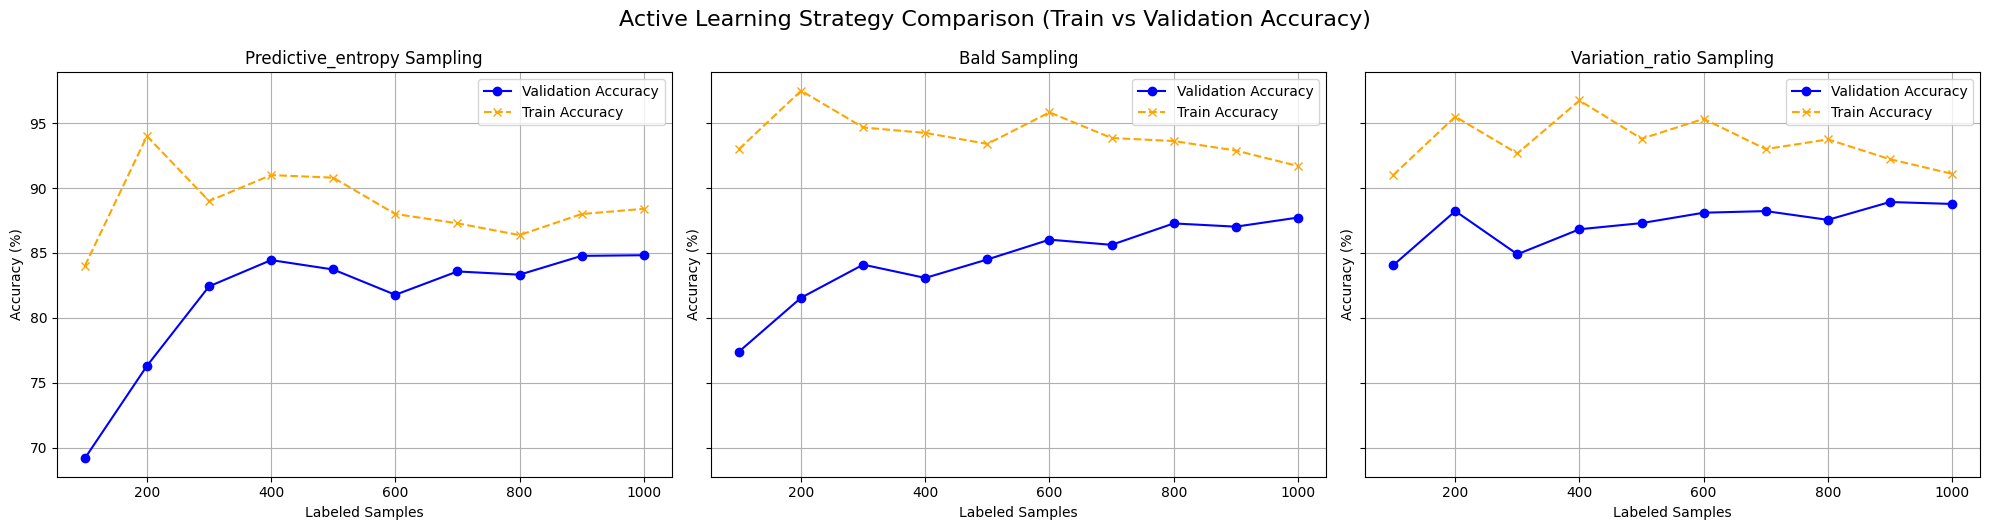

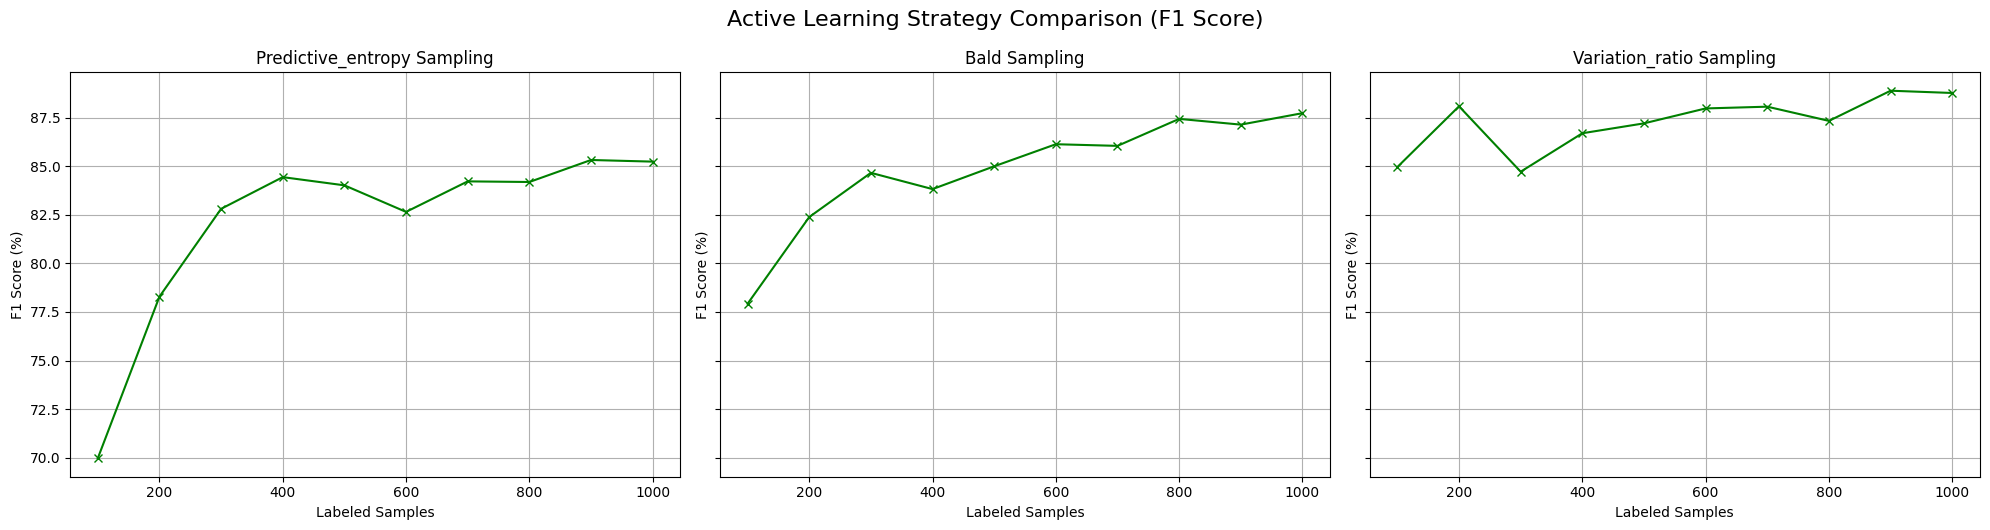

In [49]:
# Accuracy Plot: Train vs Val
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

for i, (name, history) in enumerate(strategy_histories.items()):
    val_accs = [a * 100 for a in history["val_accuracy"]]
    train_accs = [acc_list[-1] * 100 for acc_list in history["train_accuracy"]]  # last epoch of each round

    axs[i].plot(history["num_labeled"], val_accs, marker="o", label="Validation Accuracy", color="blue")
    axs[i].plot(history["num_labeled"], train_accs, marker="x", linestyle="--", label="Train Accuracy", color="orange")

    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("Accuracy (%)")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (Train vs Validation Accuracy)", fontsize=16, y=1.05)
plt.show()


# Average F1 Score Plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
for i, (name, history) in enumerate(strategy_histories.items()):
    axs[i].plot(history["num_labeled"], [a * 100 for a in history["val_avg_f1"]], marker="x", color='green')
    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("F1 Score (%)")
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (F1 Score)", fontsize=16, y=1.05)
plt.show()

<hr>